# Machine Learning Project
## Library imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split   

## Data Importation 

In [2]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')

## DataFrame Creation

It will be easier for data visualization to work with pandas dataframes

In [3]:
# Features's Names
column_names_X = ['air_tmp','water_tmp','wind_speed','wind_dir','illumination']
column_names_y = ['toxic_concentration']
column_names_X_test = ['air_tmp','water_tmp','wind_speed','wind_dir','illumination']

# Creating DataFrames
df_X_train = pd.DataFrame(X_train)
df_y_train = pd.DataFrame(y_train)
df_X_test = pd.DataFrame(X_test)

# Attributing Column Names
df_X_train.columns = column_names_X
df_y_train.columns = column_names_y
df_X_test.columns = column_names_X_test

## Data Visualization

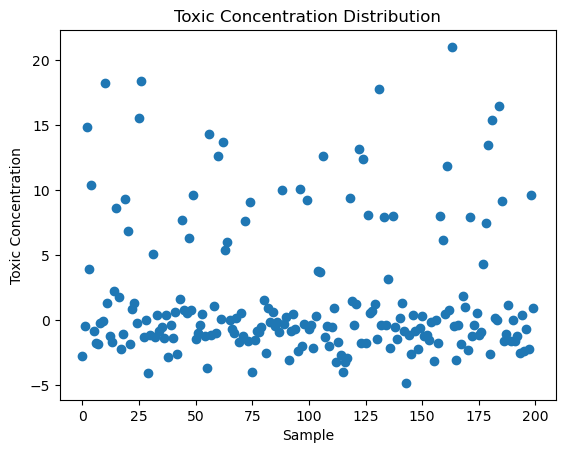

In [4]:
plt.scatter(range(0,200), y_train)
plt.title('Toxic Concentration Distribution')
plt.ylabel('Toxic Concentration')   
plt.xlabel('Sample')
plt.show()

<Figure size 1000x1000 with 0 Axes>

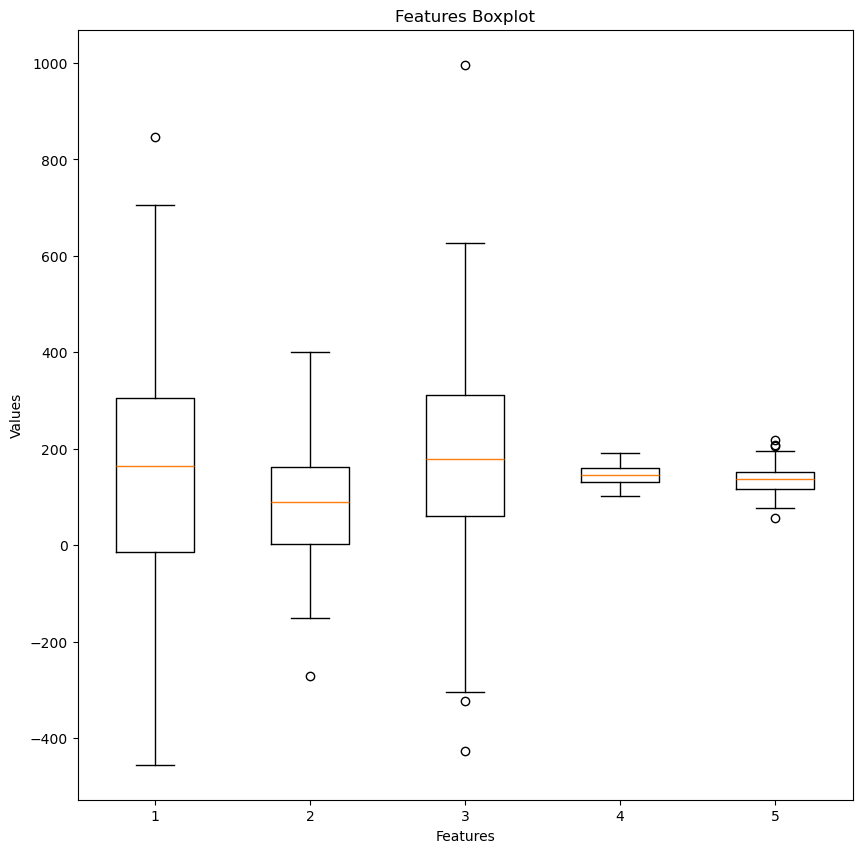

In [5]:
#boxplot of the features
plt.figure(figsize=(10,10))
# Boxplot of the features
plt.figure(figsize=(10,10))
plt.boxplot(X_train)
plt.title('Features Boxplot')
plt.ylabel('Values')
plt.xlabel('Features')
plt.show()

The points we can see on the boxplots are the outlier values of the features.

## Linear Regression - With Outliers

In [6]:
# Let's start the linear regression
lm = LinearRegression()
model = lm.fit(X_train, y_train)
print(f"\t y = {model.intercept_:.4f} + {model.coef_[0]:.4f}x_1 + {model.coef_[1]:.4f}x_2 + {model.coef_[2]:.4f}x_3 + {model.coef_[3]:.4f}x_4 + {model.coef_[4]:.4f}x_5")

	 y = -33.0704 + -0.0211x_1 + -0.0891x_2 + -0.0006x_3 + -0.0355x_4 + 0.3774x_5


Our linear regression model is : $\newline$ 
$$y = \beta_0 + \beta_1x_{1} + \beta_2x_2 + \beta_3x_3 + \beta_4x_4 + \beta_5x_5$$

$$y = -33.0704 + -0.0211 \times x_{1} + -0.0891 \times x_2 + -0.0006 \times x_3 + -0.0355 \times x_4 + 0.3774 \times x_5$$

We can see that $\beta_3$ is very low so we could try to delete $x_3$ from our model to improve time computation while having the same acurracy.

### Predictions

We are going to make the predicitons and compare them with the train set and square the result so that we will have the cuadratic loss  

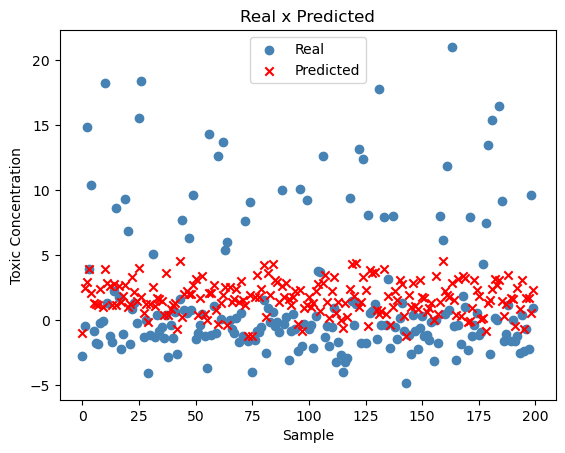

In [7]:
y_train_pred = model.predict(X_train)
plt.scatter(range(0,200), y_train, color='steelblue', marker='o', label='Real')
plt.scatter(range(0,200), y_train_pred, color='red', marker='x', label='Predicted')
plt.title('Real x Predicted')

plt.ylabel('Toxic Concentration')   
plt.xlabel('Sample')
plt.legend(loc = 'best')
plt.show()

Most of the predictions aren't good. Let's measure the SSE :

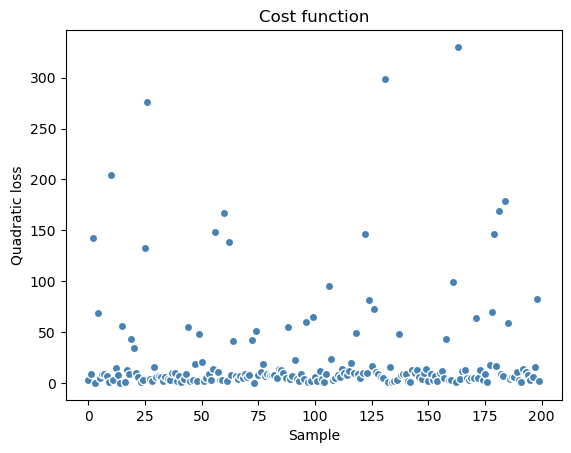

Sum of squares error mean : 25.020208183362055
Coefficient of determination : 0.060559944384204645


In [8]:
quadratic_loss = (y_train_pred - y_train)**2

plt.scatter(range(0,200), quadratic_loss, c='steelblue', marker='o',
            edgecolor='white', label='Entrenamiento')

plt.title('Cost function')
plt.ylabel('Quadratic loss')
plt.xlabel('Sample')
plt.show()

print("Sum of squares error mean :", mean_squared_error(y_train, y_train_pred))
print("Coefficient of determination :", r2_score(y_train, y_train_pred)) #coefficient of determination = 1-SSE/standard deviation 

Our first approach of the model is not working very well. As we see in the cost plot, there are big errors in some samples. The coefficient of determination whose best value, 1, is achieved when SSE=0 (no erros), is too low.  Therefore, our goal is to remove those conflicting samples and to meassure the performance of the model again.

### Residuals

Let's study the residuals in order to identify the outliers.

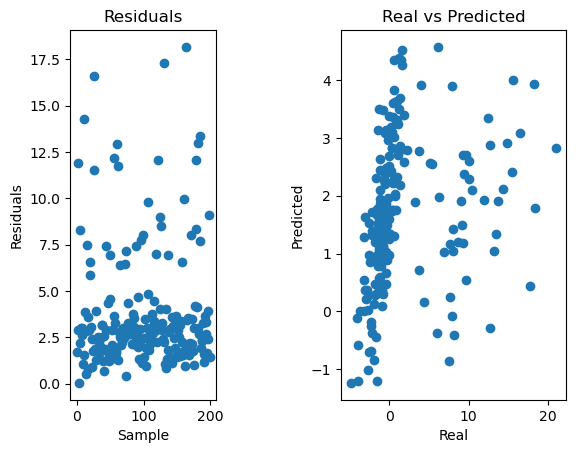

In [9]:
residuals = np.abs(y_train - y_train_pred)
plt.subplot(1,3,1)
plt.scatter(range(0,200),residuals)
plt.title('Residuals')
plt.ylabel('Residuals') 
plt.xlabel('Sample')

plt.subplot(1,2,2)
plt.scatter(y_train, y_train_pred)
plt.title('Real vs Predicted')
plt.ylabel('Predicted') 
plt.xlabel('Real')
plt.show()

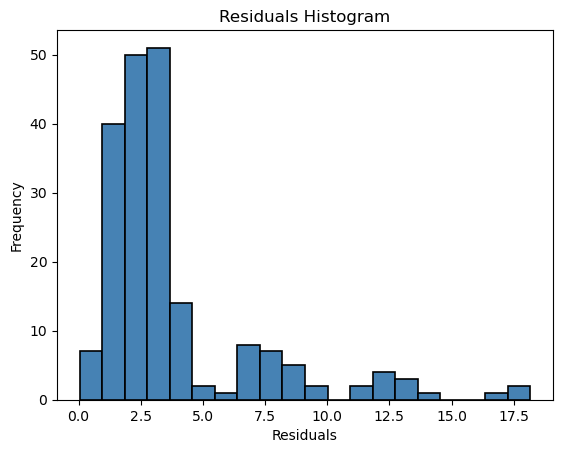

In [10]:
plt.hist(residuals, bins=20, color='steelblue', edgecolor='black', linewidth=1.2)
plt.title('Residuals Histogram')
plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.show()

We know that approximately 25% of the measurements are incorrect, and we observe four Gaussian distributions in the histogram. The first one likely corresponds to the correct measurements, while the others represent the incorrect ones.

Now, how many samples have residuals greater than 5?

In [11]:
res_g5 = residuals[residuals > 5]
print(f"Residuals greater than 5: {len(res_g5)}")

Residuals greater than 5: 36


The number of outliers considering that their residuals must me over 5 is 36.

## Finding and removing the outliers

### Three Sigma Rule

The "sigma edit" rule is a measure of the outlyingness of an observation $x_i$. The "three sigma edit" rule is defined as : 
$$t_i = \frac{x_i - \bar{x}}{s}$$

If $ |t_{i}| > 3$ then the observation is considered as "suspicious".

In [12]:
# The mean and the standard error of the features
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)

# Create a mask for the outliers
outliers_mask = np.abs((residuals - mean_residuals) / std_residuals) > 3

# Number of outliers    
print(f"Number of outliers : {outliers_mask.sum()}")

Number of outliers : 4


### Median absolute deviation about the median

The median absolute deviation about the median is the median of the absolute distance from the median is defined as :

$$MAD(\bold{x}) = Med\space\{|1-Med(\bold{x})|\}$$

The threshold of this method is $k \times MAD$,

with $k = \frac{\hat{\sigma}}{MAD}$, a constant coefficient. $k$ is choosen according to the sensitiviness we want our threshold to be.

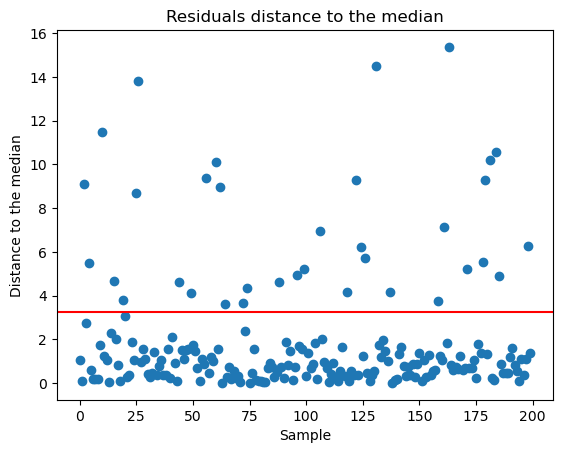

MAD:  0.9099301658650182
k:  3.5910060515418554
Number of outliers using MAD: 35


In [13]:
# MAD
mad_residuals = np.median(np.abs(residuals - np.median(residuals)))

# Sensitivity factor
k = std_residuals/ mad_residuals

# Finding the outliers using the median absolute deviation
outliers_mask_mad = np.abs(residuals - np.median(residuals)) > k * mad_residuals

# plot of the distance of the residuals to the median
plt.scatter(range(0,200),np.abs(residuals - np.median(residuals)))
plt.title('Residuals distance to the median')
plt.axhline(y=k*mad_residuals, color='r', linestyle='-')
plt.ylabel('Distance to the median')
plt.xlabel('Sample')
plt.show()

print("MAD: ", mad_residuals)
print("k: ", k)
print("Number of outliers using MAD:", outliers_mask_mad.sum())


With this method we find almost the same number of outliers as before with the histogram.

### Removing the outliers

In [14]:
# Removing the outliers using MAD
X_train_clean = X_train[~outliers_mask_mad]
y_train_clean = y_train[~outliers_mask_mad]
np.shape(X_train_clean)

(165, 5)

## Second Model - Without Outliers

### Creation of a validation set
Now that we have our clean dataset let's devide it into a training set and a validation set :

In [15]:
# Splitting the data
X_train_clean, X_val, y_train_clean, y_val = train_test_split(X_train_clean, y_train_clean, test_size=0.2, random_state=0)

### Linear Regression

In [16]:
# Let's start the linear regression
lm = LinearRegression()
model_2 = lm.fit(X_train_clean, y_train_clean)
print(f"\t y = {model_2.intercept_:.4f} + {model_2.coef_[0]:.4f}x_1 + {model_2.coef_[1]:.4f}x_2 + {model_2.coef_[2]:.4f}x_3 + {model_2.coef_[3]:.4f}x_4 + {model_2.coef_[4]:.4f}x_5")

	 y = -4.9634 + -0.0075x_1 + -0.0247x_2 + -0.0004x_3 + -0.0130x_4 + 0.0725x_5


### Predictions

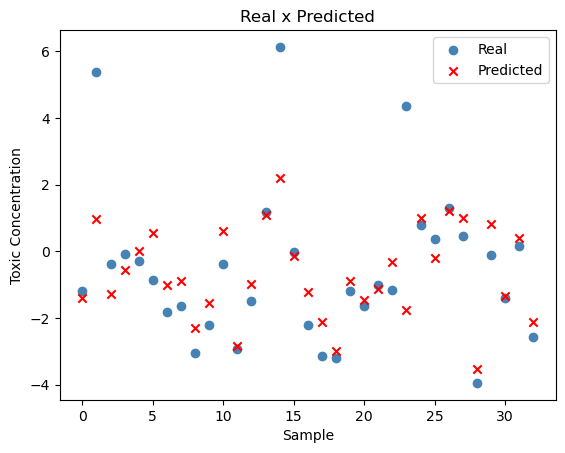

In [17]:
y_val_pred = model_2.predict(X_val)

plt.scatter(range(0,np.shape(y_val)[0]), y_val, color='steelblue', marker='o', label='Real')
plt.scatter(range(0,np.shape(y_val_pred)[0]), y_val_pred, color='red', marker='x', label='Predicted')

plt.title('Real x Predicted')
plt.ylabel('Toxic Concentration')
plt.xlabel('Sample')    
plt.legend(loc='upper right') 
plt.show()


As we can see, the predictions are almost identical to the actual values. Let's study the residuals : 

### Residuals

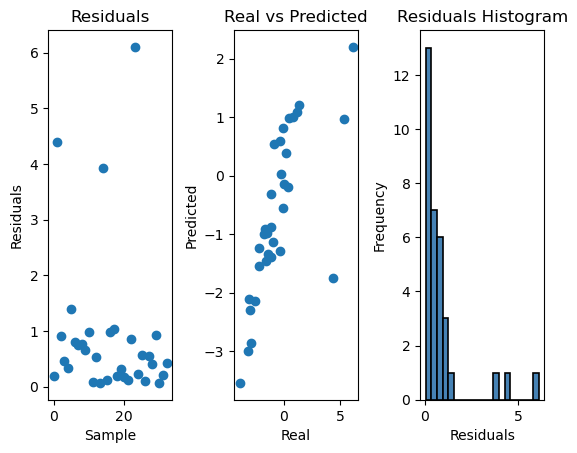

Sum of squares error mean : 2.5298832871641785
Coefficient of determination : 0.5054286227709013


In [18]:
residuals = np.abs(y_val - y_val_pred)
plt.subplot(1,3,1)
plt.scatter(range(0,np.shape(residuals)[0]),residuals)
plt.title('Residuals')
plt.ylabel('Residuals') 
plt.xlabel('Sample')

plt.subplot(1,3,2)
plt.scatter(y_val, y_val_pred)
plt.title('Real vs Predicted')
plt.ylabel('Predicted') 
plt.xlabel('Real')

plt.subplot(1,3,3)
plt.hist(residuals, bins=20, color='steelblue', edgecolor='black', linewidth=1.2)
plt.title('Residuals Histogram')
plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.subplots_adjust(wspace=0.5)

plt.show()

print("Sum of squares error mean :", mean_squared_error(y_val, y_val_pred))
print("Coefficient of determination :", r2_score(y_val, y_val_pred)) 


As we can see, the SSE is significantly lower and the coefficient of determination higher than before. However, we could potentially enhance the model further by applying regularization techniques.

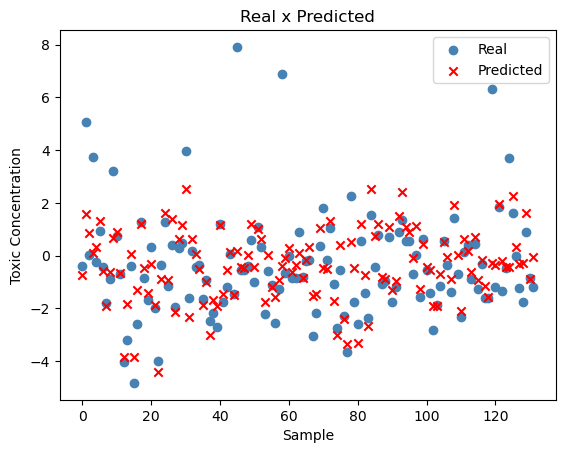

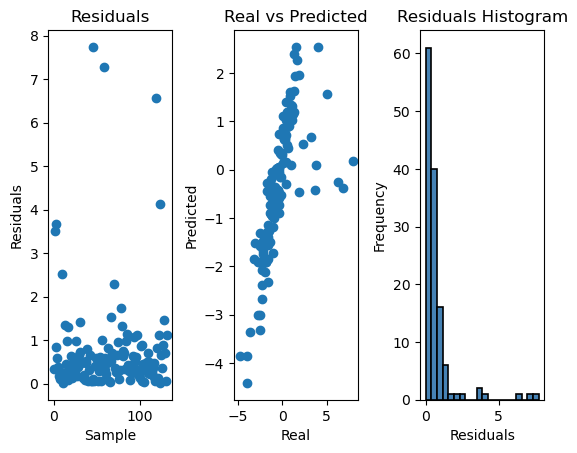

Sum of squares error mean : 1.9471081520840328
Coefficient of determination : 0.483329453459465


In [19]:
y_clean_pred = model_2.predict(X_train_clean)
plt.scatter(range(0,np.shape(y_train_clean)[0]), y_train_clean, color='steelblue', marker='o', label='Real')
plt.scatter(range(0,np.shape(y_train_clean)[0]), y_clean_pred, color='red', marker='x', label='Predicted')
plt.title('Real x Predicted')
plt.ylabel('Toxic Concentration')
plt.xlabel('Sample')
plt.legend(loc='upper right')
plt.show()

residuals = np.abs(y_train_clean - y_clean_pred)
plt.subplot(1,3,1)
plt.scatter(range(0,np.shape(residuals)[0]),residuals)
plt.title('Residuals')
plt.ylabel('Residuals')
plt.xlabel('Sample')

plt.subplot(1,3,2)
plt.scatter(y_train_clean, y_clean_pred)
plt.title('Real vs Predicted')
plt.ylabel('Predicted')
plt.xlabel('Real')

plt.subplot(1,3,3)
plt.hist(residuals, bins=20, color='steelblue', edgecolor='black', linewidth=1.2)
plt.title('Residuals Histogram')
plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.subplots_adjust(wspace=0.5)
plt.show()

print("Sum of squares error mean :", mean_squared_error(y_train_clean, y_clean_pred))
print("Coefficient of determination :", r2_score(y_train_clean, y_clean_pred)) 



The SSE decreased, but not significantly because the outliers remain unnoticed. 

We are now gonna use regularization methods in order to improve the performance of our linear model.

### Finding the best threshold 

Let's try to find the best threshold to minimize the SSE :


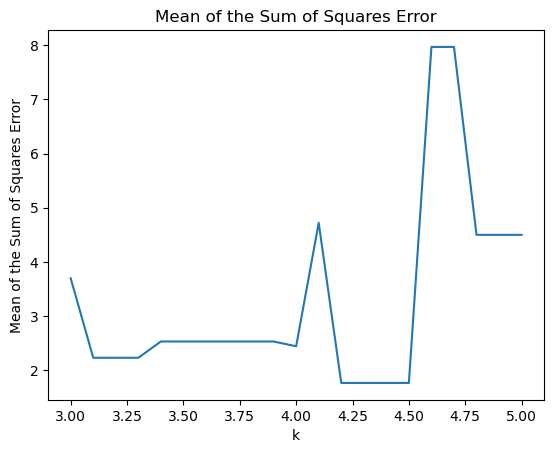

The minimum of SSE is  1.7650123058313214 for k = 4.200000000000001


In [20]:
list_SSE_mean = []

seq_k = np.arange(3.0, 5.1, 0.1)

#for j in range(1, 10):  
for j in seq_k :

    residuals = np.abs(y_train - y_train_pred)
    
    mad_residuals = np.median(np.abs(residuals - np.median(residuals)))

    #finding the outliers using the median absolute deviation
    outliers_mask_mad = np.abs(residuals - np.median(residuals)) > j * mad_residuals

    # Removing the outliers using MAD
    X_train_clean = X_train[~outliers_mask_mad]
    y_train_clean = y_train[~outliers_mask_mad]
    np.shape(X_train_clean)

    #splitting the data
    X_train_clean, X_val, y_train_clean, y_val = train_test_split(X_train_clean, y_train_clean, test_size=0.2, random_state=0)

    # Let's start the linear regression
    lm = LinearRegression()
    model = lm.fit(X_train_clean, y_train_clean)

    y_val_pred = model.predict(X_val)
    residuals = np.abs(y_val - y_val_pred)
    list_SSE_mean.append(mean_squared_error(y_val, y_val_pred))

plt.plot(np.arange(3, 5.1, 0.1), list_SSE_mean)
plt.title('Mean of the Sum of Squares Error')
plt.ylabel('Mean of the Sum of Squares Error')
plt.xlabel('k')
plt.show()

# The minimum value of the list and the index  
min_value = min(list_SSE_mean)
k_indx = np.where(min(list_SSE_mean) == list_SSE_mean)[0][0]
k = seq_k[k_indx]
print("The minimum of SSE is ",list_SSE_mean[k_indx],"for k =",k)


The best value for $k$ is not $k=1$ because it removes 100 samples from the dataset. 

The best value is somewhere between 3 and 5, and it is actually between 4.2 and 4.5 since the SSE is equal for each k between those values.

In [21]:
residuals = np.abs(y_train - y_train_pred)

# Finding the outliers using the median absolute deviation
outliers_mask_mad = np.abs(residuals - np.median(residuals)) > k * mad_residuals
print("There are",outliers_mask_mad.sum(),"outliers according to the MAD")

# Removing the outliers using MAD
X_train_clean = X_train[~outliers_mask_mad]
y_train_clean = y_train[~outliers_mask_mad]


#splitting the data
X_train_clean, X_val, y_train_clean, y_val = train_test_split(X_train_clean, y_train_clean, test_size=0.2, random_state=0)

#Train the model again withou the outliers
lr_mad = LinearRegression()
lr_mad.fit(X_train_clean, y_train_clean)
y_val_pred = lr_mad.predict(X_val)
print("Coefficient of determination :", r2_score(y_val, y_val_pred)) 


There are 31 outliers according to the MAD
Coefficient of determination : 0.26734031326464724


## Regularization techniques

### L1 Regularization

Let's try Lasso Regularization :

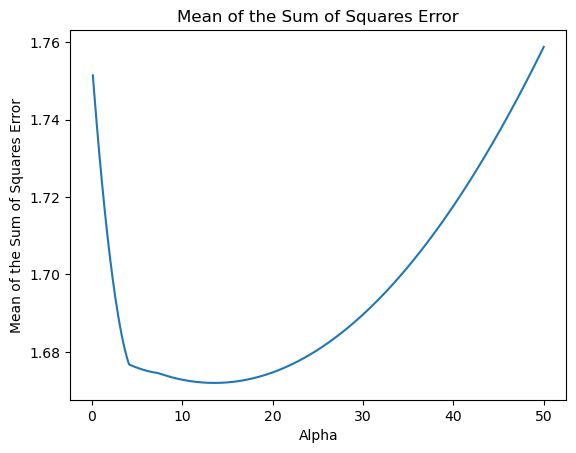

The minimum of SSE is  1.671958479900983 for alpha = 13.6


In [22]:
# Model creation
seq_alpha = np.arange(0.1, 50.1, 0.1)
list_SSE_mean = []

for alpha in seq_alpha:
    L1 = Lasso(alpha=alpha)

    # Model training
    L1.fit(X_train_clean, y_train_clean)

    # Prediction ingoring atypical samples
    y_l1_pred = L1.predict(X_val)
    list_SSE_mean.append(mean_squared_error(y_val, y_l1_pred))

plt.plot(seq_alpha, list_SSE_mean)
plt.title('Mean of the Sum of Squares Error')
plt.ylabel('Mean of the Sum of Squares Error')
plt.xlabel('Alpha')
plt.show()

# The minimum value of the list and the index
min_value = min(list_SSE_mean)
alpha_indx = np.where(min(list_SSE_mean) == list_SSE_mean)[0][0]
l1_alpha = seq_alpha[alpha_indx]
print("The minimum of SSE is ",list_SSE_mean[alpha_indx],"for alpha =",l1_alpha)

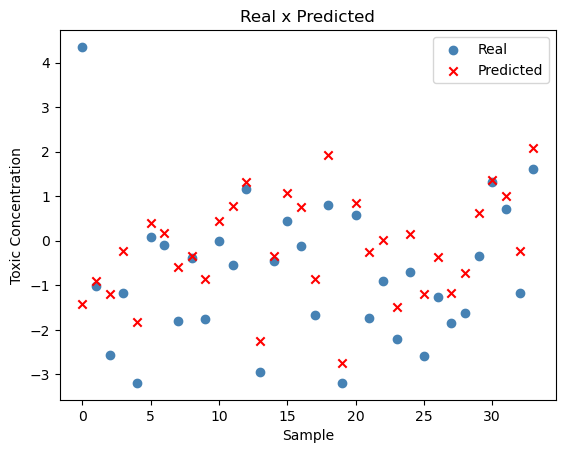

Coefficient of determination =  0.3059671187154662
Number of features after regularization = 2 
[-0.00419876 -0.00764772 -0.         -0.         -0.        ]


In [23]:
# Model creation    
L1 = Lasso(alpha=l1_alpha)

# Model training
L1.fit(X_train_clean, y_train_clean)

# Prediction ingoring atypical samples
y_l1_pred = L1.predict(X_val)

plt.scatter(range(0,np.shape(y_val)[0]), y_val, color='steelblue', marker='o', label='Real')
plt.scatter(range(0,np.shape(y_l1_pred)[0]), y_l1_pred, color='red', marker='x', label='Predicted')
plt.title('Real x Predicted')
plt.ylabel('Toxic Concentration')
plt.xlabel('Sample')
plt.legend(loc='upper right')   
plt.show()

print('Coefficient of determination = ',r2_score(y_val, y_l1_pred))
print('Number of features after regularization = %d ' % (np.count_nonzero(L1.coef_)))
print(L1.coef_)

The SSE decreased by 0.1. Despite the fact that the regularizarion has been able to make some features null, the performace of this model is worse.

### L2 Regularization

Let's try Ridge regularization :

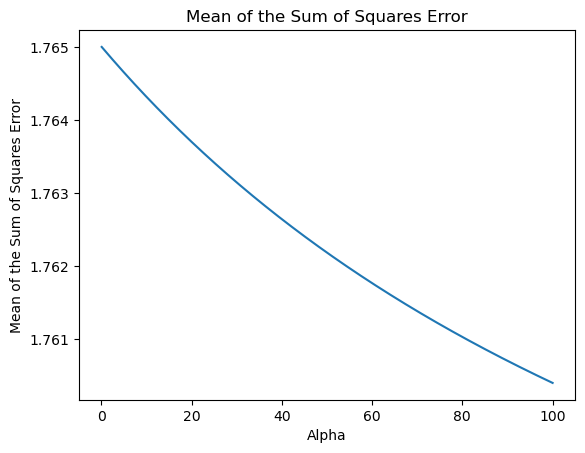

The minimum of SSE is  1.7604021557518832 for alpha = 100.0


In [24]:
# Model creation
seq_alpha = np.arange(0.1, 100.1, 0.1)
list_SSE_mean = []

for alpha in seq_alpha:

    # Model creation
    L2 = Ridge(alpha=alpha)

    # Model training
    L2.fit(X_train_clean, y_train_clean)

    # Prediction ingoring atypical samples
    y_l2_pred = L2.predict(X_val)
    list_SSE_mean.append(mean_squared_error(y_val, y_l2_pred))

plt.plot(seq_alpha, list_SSE_mean)
plt.title('Mean of the Sum of Squares Error')
plt.ylabel('Mean of the Sum of Squares Error')
plt.xlabel('Alpha')
plt.show()

# The minimum value of the list and the index
min_value = min(list_SSE_mean)
alpha_indx = np.where(min(list_SSE_mean) == list_SSE_mean)[0][0]
l2_alpha = seq_alpha[alpha_indx]
print("The minimum of SSE is ",list_SSE_mean[alpha_indx],"for alpha =",l2_alpha)

Coefficient of determination =  0.2692539946037772


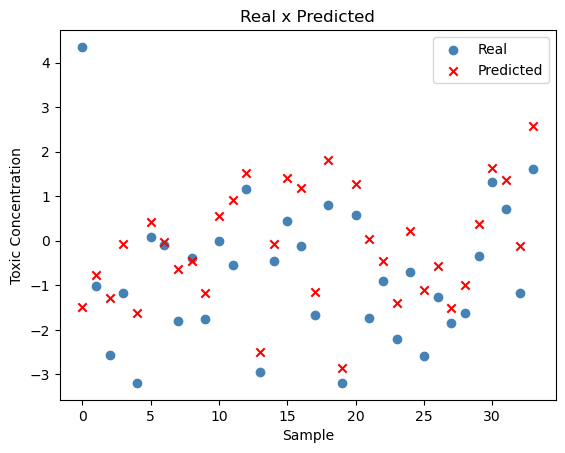

In [25]:
# Model creation
L2 = Ridge(alpha=l2_alpha)

# Model training
L2.fit(X_train_clean, y_train_clean)

# Prediction ingoring atypical samples
y_l2_pred = L2.predict(X_val)

plt.scatter(range(0,np.shape(y_val)[0]), y_val, color='steelblue', marker='o', label='Real')
plt.scatter(range(0,np.shape(y_l2_pred)[0]), y_l2_pred, color='red', marker='x', label='Predicted')
plt.title('Real x Predicted')
plt.ylabel('Toxic Concentration')
plt.xlabel('Sample')
plt.legend(loc='upper right')

print('Coefficient of determination = ',r2_score(y_val, y_l2_pred))

When $\alpha$ increases, the SSE decreases, but at a slow rate. Therefore, we can choose $\alpha = 50$.

However, the performance parameters are still worse than with Lasso regularization, so we will keep using Lasso regularization.

### L1 + L2 Regularization

Let's try the Elastic Net regularization with a bigger l1_ratio because the Lasso regression do better than the ridge:

In [26]:
# Model creation
seq_l1_ratio = np.arange(0.5,1.0,0.1)
mat_SSE_mean = np.zeros((1001, 6))
seq_alpha = np.arange(0.1,100.1,0.1)

i = 0
j = 0
for alpha in seq_alpha:
    j = 0
    for l1_ratio in seq_l1_ratio:
        j = j + 1
        elastNet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

        # Model training
        elastNet.fit(X_train_clean, y_train_clean)

        # Prediction ingoring atypical samples
        y_elas_pred = elastNet.predict(X_val)
        mat_SSE_mean[i][j] = mean_squared_error(y_val, y_elas_pred)
    i = i + 1

# We have to drop the first column and last row
mat_SSE_mean = np.delete(mat_SSE_mean, 0, 1)
mat_SSE_mean = np.delete(mat_SSE_mean, -1, 0)
print(mat_SSE_mean)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.819e+00, tolerance: 8.385e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.501e-01, tolerance: 8.385e-02
  model = cd_fast.enet_coordinate_descent(


[[1.75424066 1.75295133 1.75236483 1.7520639  1.75176312]
 [1.75143075 1.75082983 1.75023434 1.74964107 1.74904987]
 [1.74990598 1.74901885 1.74813562 1.74725738 1.74638413]
 ...
 [1.7594954  1.81326726 1.87998291 1.95968892 2.05243209]
 [1.75973495 1.81363213 1.88049917 1.96038281 2.05332995]
 [1.75997483 1.81399747 1.88101608 1.96107753 2.05422887]]


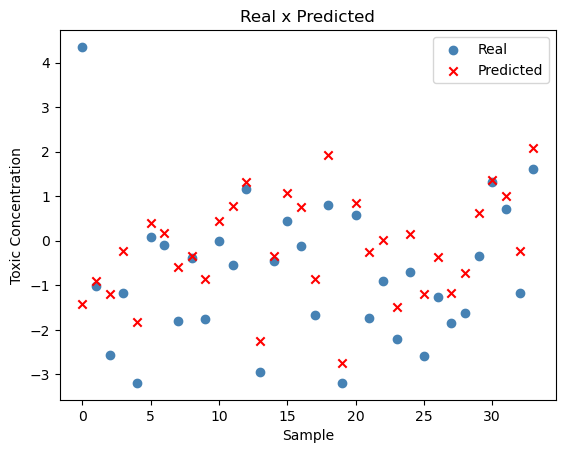

The minimum of SSE is 1.6719647210821016 for alpha = 15.0 and l1_ratio = 0.8999999999999999
Coefficient of determination =  0.30596452799029783
Number of features after regularization = 2 


In [27]:
# Finding the minimum value of the matrix and the index
min_value = np.min(mat_SSE_mean)
min_indx = np.where(np.min(mat_SSE_mean) == mat_SSE_mean)
elas_alpha = seq_alpha[min_indx[0][0]]
l1_ratio = seq_l1_ratio[min_indx[1][0]]

# Let's start the regularization
elastNet = ElasticNet(alpha=elas_alpha, l1_ratio=l1_ratio)

# Model training
elastNet.fit(X_train_clean, y_train_clean)

# Prediction ingoring atypical samples
y_elas_pred = elastNet.predict(X_val)

plt.scatter(range(0,np.shape(y_val)[0]), y_val, color='steelblue', marker='o', label='Real')
plt.scatter(range(0,np.shape(y_elas_pred)[0]), y_elas_pred, color='red', marker='x', label='Predicted')
plt.title('Real x Predicted')
plt.ylabel('Toxic Concentration')
plt.xlabel('Sample')
plt.legend(loc='upper right')
plt.show()

print("The minimum of SSE is",min_value,"for alpha =",elas_alpha,"and l1_ratio =",l1_ratio)
print('Coefficient of determination = ',r2_score(y_val, y_elas_pred))
print('Number of features after regularization = %d ' % (np.count_nonzero(elastNet.coef_)))


All of these regularization techniques slightly improved the performance of the previous model, but the improvement was not substantial. 
Our best model was the one with Lasso regularization.

In [28]:
print("The linear model is :\n\t y = {0:.4f} + {1:.4f}x_1 + {2:.4f}x_2".format(L1.intercept_,
                             L1.coef_[0], L1.coef_[1]))

The linear model is :
	 y = 1.2100 + -0.0042x_1 + -0.0076x_2


## Removing the outliers - RANSAC Algorithm

One advantage of using the RANSAC algorithm is that it removes the outliers by itself, so we don't need to remove them from our training set in advance. In this case, we've decided to use the "squared_error" metics as the measure to take into account when looking for outliers. They'll be considered that way if they exceed a selected threshold.

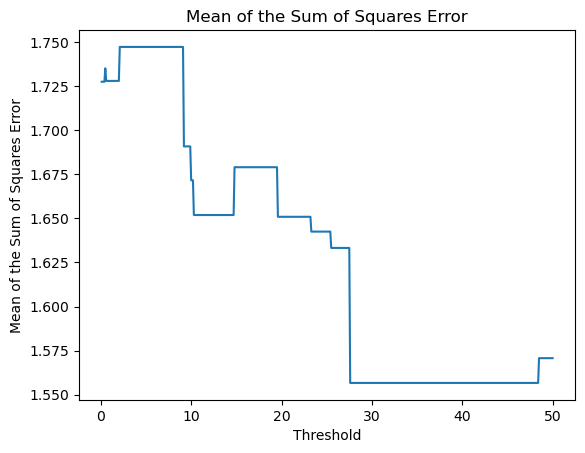

The minimum of SSE is  1.5566463370976802 with a threshold of = 27.6


In [29]:
# Treshold selection:
sec_threshold = np.arange(0.1, 50.1, 0.1)
list_SSE_mean = []

for treshold in sec_threshold:

    # Model creation
    ransac = RANSACRegressor(LinearRegression(), max_trials=200, min_samples=None, 
                            loss='squared_error', residual_threshold=treshold, random_state=0)
    
    # Model training
    ransac.fit(X_train, y_train)
  
    # Prediction ingoring atypical samples
    y_ransac_pred = ransac.predict(X_val)
    list_SSE_mean.append(mean_squared_error(y_val, y_ransac_pred))

plt.plot(sec_threshold, list_SSE_mean)
plt.title('Mean of the Sum of Squares Error')
plt.ylabel('Mean of the Sum of Squares Error')
plt.xlabel('Threshold')
plt.show()

# The minimum value of the list and the index
min_value = min(list_SSE_mean)
threshold_indx = np.where(min(list_SSE_mean) == list_SSE_mean)[0][0]
ransac_threshold = sec_threshold[threshold_indx]
print("The minimum of SSE is ",list_SSE_mean[threshold_indx],"with a threshold of =",ransac_threshold)


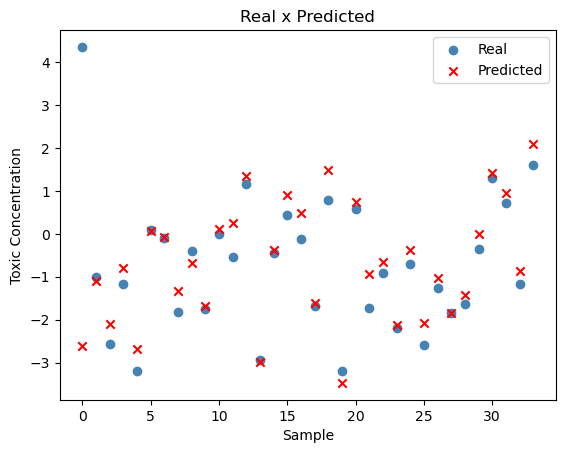

There are 39 outliers in the training set according to RANSAC
Coefficient of determination =  0.6594960896016144


In [30]:
# Model creation
ransac = RANSACRegressor(LinearRegression(), max_trials=200, min_samples=None, 
                        loss='squared_error', residual_threshold=ransac_threshold, random_state=0)

# Model training
ransac.fit(X_train, y_train)

# Prediction ingoring atypical samples
y_ransac_pred = ransac.predict(X_val)

plt.scatter(range(0,np.shape(y_val)[0]), y_val, color='steelblue', marker='o', label='Real')
plt.scatter(range(0,np.shape(y_ransac_pred)[0]), y_ransac_pred, color='red', marker='x', label='Predicted')

plt.title('Real x Predicted')
plt.ylabel('Toxic Concentration')
plt.xlabel('Sample')
plt.legend(loc='upper right')   
plt.show()

# Finding the "atypical" samples 
typic_sample_mask = ransac.inlier_mask_ #Typical samples
atypic_sample_mask = np.logical_not(typic_sample_mask) #Atypical samples

# Locating those samples 
typic_sample_position = np.where(typic_sample_mask)[0]
atypic_sample_position = np.where(atypic_sample_mask)[0]

# Removing the outliers from the datasets 
X_train_clean = X_train[typic_sample_position]
y_train_clean = y_train[typic_sample_position]

# Splitting the data
X_train_clean, X_val, y_train_clean, y_val = train_test_split(X_train_clean, y_train_clean, test_size=0.2, random_state=0)

# Prediction
y_val_pred = ransac.predict(X_val)

print("There are",atypic_sample_mask.sum(),"outliers in the training set according to RANSAC")
print('Coefficient of determination = ',r2_score(y_val, y_val_pred))


In [31]:
print(f"\t y = {ransac.estimator_.intercept_:.4f} + {ransac.estimator_.coef_[0]:.4f}x_1 + {ransac.estimator_.coef_[1]:.4f}x_2 + {ransac.estimator_.coef_[2]:.4f}x_3 + {ransac.estimator_.coef_[3]:.4f}x_4 + {ransac.estimator_.coef_[4]:.4f}x_5")

	 y = 1.2783 + -0.0053x_1 + -0.0085x_2 + -0.0006x_3 + -0.0047x_4 + 0.0037x_5


After doing all this analysis we conclude that the best model for this concrete exercise is the RANSAC algorithm with the squared error as a metric. Therefore, our model will be:

$$y = \beta_0 + \beta_1x_{1} + \beta_2x_2 + \beta_3x_3 + \beta_4x_4 + \beta_5x_5$$

$$y = 1.2783 - 0.0053 \times x_{1} - 0.0085 \times x_2 - 0.0006 \times x_3 - 0.0047 \times x_4 + 0.0037 \times x_5$$

So we proceed to predict the output of the test set with our selected model:

In [32]:
y_solution = ransac.predict(X_test) 
np.shape(y_solution)
np.save('y_test', y_solution)